Uso de LTSM con el dataset en formato de series temporales tridimensional: (num_registros, años, features)

In [ ]:
import pandas as pd
#from google.colab import drive
import numpy as np
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV,cross_val_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense,Dropout,Conv1D, GlobalMaxPooling1D
from sklearn.metrics import confusion_matrix,roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

from xgboost import XGBClassifier,plot_importance
from sklearn.metrics import accuracy_score,precision_score, recall_score, f1_score, roc_auc_score
from imblearn.over_sampling import SMOTE,ADASYN,KMeansSMOTE

from sklearn.decomposition import PCA


from sklearn.pipeline import Pipeline

from sklearn.ensemble import RandomForestClassifier

from sklearn.impute import SimpleImputer


from tensorflow.keras.callbacks import EarlyStopping
#import shap


In [ ]:

ruta='../../data/'


df_combined = pd.read_csv(ruta+'dfCombinado.csv')



In [ ]:
df_combined

,ID,Endeudamiento2010,Endeudamiento2011,Endeudamiento2012,Endeudamiento2013,Endeudamiento2014,Endeudamiento2015,Endeudamiento2016,Endeudamiento2017,Endeudamiento2018,...,Zombi2018,Zombi2019,Zombi2020,Zombi2021,Zombi2022,Zombi2016-2018,Zombi2017-2019,Zombi2018-2020,Zombi2019-2021,Zombi2020-2022
0,2.331510e+05,0.481564,0.504275,0.528986,0.526416,0.438958,0.421232,0.456693,0.444376,0.437555,...,0,0,0,0,0,0,0,0,0,0
1,2.332070e+05,0.417697,0.438167,0.419161,0.405979,0.415085,0.421306,0.423336,0.417468,0.418792,...,0,0,0,0,0,0,0,0,0,0
2,2.332350e+05,0.390563,0.390563,0.390563,0.386473,0.398405,0.402884,0.392962,0.397971,0.394088,...,0,0,0,0,0,0,0,0,0,0
3,2.332840e+05,0.461182,0.423969,0.422467,0.420274,0.440206,0.471725,0.459850,0.459710,0.455228,...,0,0,0,0,0,0,0,0,0,0
4,2.332910e+05,0.438801,0.420453,0.415624,0.411939,0.418133,0.416285,0.439980,0.437075,0.441119,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12261,2.120828e+10,0.431598,0.431598,0.431598,0.427784,0.437189,0.437174,0.433567,0.390638,0.392090,...,1,0,0,1,0,0,0,0,0,0
12262,2.120849e+10,0.619078,0.619078,0.619078,0.616522,0.614381,0.613338,0.610860,0.610860,0.744588,...,0,0,0,0,0,0,0,0,0,0
12263,2.121003e+10,0.702200,0.702200,0.702200,0.700202,0.692943,0.691444,0.689467,0.689467,0.725373,...,0,0,0,0,0,0,0,0,0,0
12264,2.121895e+10,0.420357,0.420357,0.420357,0.416468,0.426565,0.426611,0.500286,0.440874,0.409549,...,0,0,0,0,1,0,0,0,0,0


In [ ]:
# Preparar los datos para el modelo
feature_Endeudamiento = [col for col in df_combined.columns if 'Endeudamiento'  in col and '2022' not in col]
feature_Solvencia = [col for col in df_combined.columns if 'Solvencia'  in col and '2022' not in col]
feature_Patrimonio = [col for col in df_combined.columns if 'PT'  in col and '2022' not in col]
feature_Gfinancieros = [col for col in df_combined.columns if 'RAGXFI'  in col and '2022' not in col]
feature_Fmaniobra = [col for col in df_combined.columns if 'FondoManiobra'  in col and '2022' not in col]
feature_Resultados = [col for col in df_combined.columns if 'R2'  in col and '2022' not in col]
feature_Activos = [col for col in df_combined.columns if 'AC2'  in col and '2022' not in col]

feature_zombis = ['Zombi2010','Zombi2011', 'Zombi2012', 'Zombi2013', 'Zombi2014', 'Zombi2015', 'Zombi2016', 'Zombi2017', 'Zombi2018', 'Zombi2019', 'Zombi2020', 'Zombi2021']


target_column="Zombi2022"




X1 = df_combined[feature_Endeudamiento].values
X2 = df_combined[feature_Solvencia].values
X3 = df_combined[feature_Patrimonio].values
X4 = df_combined[feature_Gfinancieros].values
X5 = df_combined[feature_Fmaniobra].values
X6 = df_combined[feature_Resultados].values
X7 = df_combined[feature_Activos].values
X8 = df_combined[feature_zombis].values



# Expansión de dimensiones de x1 y x2 para permitir la concatenación
X1 = np.expand_dims(X1, axis=2)
X2 = np.expand_dims(X2, axis=2)
X3 = np.expand_dims(X3, axis=2)
X4 = np.expand_dims(X4, axis=2)
X5 = np.expand_dims(X5, axis=2)
X6 = np.expand_dims(X6, axis=2)
X7 = np.expand_dims(X7, axis=2)
X8 = np.expand_dims(X8, axis=2)



X=np.concatenate([X1, X2,X3,X4,X5,X6,X7,X8], axis=2)
y = df_combined[target_column].values

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Verificar las dimensiones de los datos transformados
(X_train.shape, X_test.shape,y_train.shape,y_test.shape)

((9812, 12, 8), (2454, 12, 8), (9812,), (2454,))

In [ ]:
X1.shape,X2.shape,X3.shape,X4.shape,X5.shape,X6.shape,X7.shape,X8.shape


((12266, 12, 1),
 (12266, 12, 1),
 (12266, 12, 1),
 (12266, 12, 1),
 (12266, 12, 1),
 (12266, 12, 1),
 (12266, 12, 1),
 (12266, 12, 1))

In [ ]:

model_LTSM = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train.shape[1],X_train.shape[2])),
    Dropout(0.2),
    LSTM(50),
    Dropout(0.2),
    Dense(50, activation='relu'),
    Dense(1, activation='sigmoid')
])

model_LTSM.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model_LTSM.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_split=0.2,  # Usando el 20% de los datos de entrenamiento para validación
    callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]
)


Epoch 1/20
246/246 [==============================] - 7s 15ms/step - loss: 0.3817 - accuracy: 0.8616 - val_loss: 0.3398 - val_accuracy: 0.8625
Epoch 2/20
246/246 [==============================] - 4s 16ms/step - loss: 0.3413 - accuracy: 0.8643 - val_loss: 0.3193 - val_accuracy: 0.8737
Epoch 3/20
246/246 [==============================] - 4s 15ms/step - loss: 0.3298 - accuracy: 0.8681 - val_loss: 0.3146 - val_accuracy: 0.8762
Epoch 4/20
246/246 [==============================] - 3s 14ms/step - loss: 0.3265 - accuracy: 0.8731 - val_loss: 0.3152 - val_accuracy: 0.8772
Epoch 5/20
246/246 [==============================] - 3s 13ms/step - loss: 0.3250 - accuracy: 0.8717 - val_loss: 0.3139 - val_accuracy: 0.8793
Epoch 6/20
246/246 [==============================] - 3s 13ms/step - loss: 0.3241 - accuracy: 0.8720 - val_loss: 0.3150 - val_accuracy: 0.8793
Epoch 7/20
246/246 [==============================] - 3s 14ms/step - loss: 0.3236 - accuracy: 0.8708 - val_loss: 0.3130 - val_accuracy: 0.8788

In [ ]:


model_CNN = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1],X_train.shape[2])),
    GlobalMaxPooling1D(),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

model_CNN.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model_CNN.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_split=0.2
)

Epoch 1/10
246/246 [==============================] - 4s 9ms/step - loss: 0.3940 - accuracy: 0.8542 - val_loss: 0.3449 - val_accuracy: 0.8625
Epoch 2/10
246/246 [==============================] - 2s 7ms/step - loss: 0.3508 - accuracy: 0.8627 - val_loss: 0.3369 - val_accuracy: 0.8681
Epoch 3/10
246/246 [==============================] - 2s 8ms/step - loss: 0.3452 - accuracy: 0.8639 - val_loss: 0.3365 - val_accuracy: 0.8716
Epoch 4/10
246/246 [==============================] - 2s 8ms/step - loss: 0.3439 - accuracy: 0.8634 - val_loss: 0.3360 - val_accuracy: 0.8645
Epoch 5/10
246/246 [==============================] - 2s 8ms/step - loss: 0.3418 - accuracy: 0.8672 - val_loss: 0.3308 - val_accuracy: 0.8706
Epoch 6/10
246/246 [==============================] - 2s 8ms/step - loss: 0.3429 - accuracy: 0.8651 - val_loss: 0.3354 - val_accuracy: 0.8650
Epoch 7/10
246/246 [==============================] - 2s 8ms/step - loss: 0.3392 - accuracy: 0.8670 - val_loss: 0.3314 - val_accuracy: 0.8691
Epoch 

In [ ]:
# Creación de un DataFrame para almacenar las métricas
df_metricas = pd.DataFrame(index=["LTSM","CNN"])

77/77 [==============================] - 1s 6ms/step


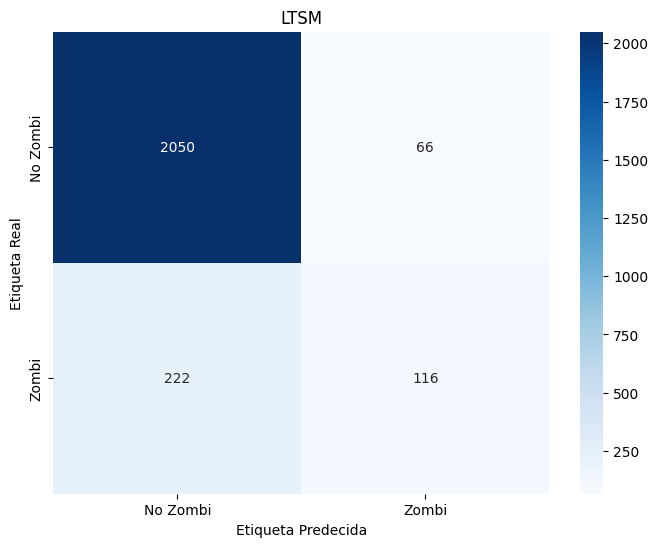

In [ ]:
# Predecir las etiquetas para el conjunto de testeo

y_pred_probs = model_LTSM.predict(X_test)
y_pred = (y_pred_probs > 0.5).astype(int)

df_metricas.loc["LTSM", "Accuracy"] =  accuracy_score(y_test, y_pred)
#df_metricas.loc["LTSM", "Balanced Accuracy"] = balanced_accuracy(y_test, y_pred)
df_metricas.loc["LTSM", "Precision"] = precision_score(y_test, y_pred)
df_metricas.loc["LTSM", "Recall"] = recall_score(y_test, y_pred)
df_metricas.loc["LTSM", "F1 Score"] = f1_score(y_test,y_pred)
# Calcular la matriz de confusión TEST
conf_matrix = confusion_matrix(y_test, y_pred)


# Nombres de las clases para el heatmap
class_names = ['No Zombi', 'Zombi']

# Crear el heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

# Añadir títulos y etiquetas para claridad
plt.title('LTSM')
plt.ylabel('Etiqueta Real')
plt.xlabel('Etiqueta Predecida')

# Mostrar la visualización
plt.show()

77/77 [==============================] - 0s 3ms/step


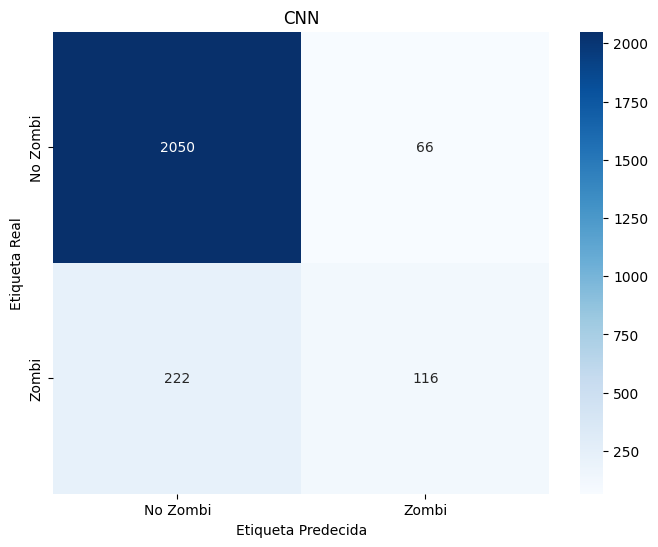

In [ ]:
# Predecir las etiquetas para el conjunto de testeo
y_pred = model_CNN.predict(X_test)
y_pred = (y_pred_probs > 0.5).astype(int)

df_metricas.loc["CNN", "Accuracy"] =  accuracy_score(y_test, y_pred)

df_metricas.loc["CNN", "Precision"] = precision_score(y_test, y_pred)
df_metricas.loc["CNN", "Recall"] = recall_score(y_test, y_pred)
df_metricas.loc["CNN", "F1 Score"] = f1_score(y_test,y_pred)

# Calcular la matriz de confusión TEST
conf_matrix = confusion_matrix(y_test, y_pred)


# Nombres de las clases para el heatmap
class_names = ['No Zombi', 'Zombi']

# Crear el heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

# Añadir títulos y etiquetas para claridad
plt.title('CNN')
plt.ylabel('Etiqueta Real')
plt.xlabel('Etiqueta Predecida')

# Mostrar la visualización
plt.show()

In [ ]:
df_metricas

,Accuracy,Precision,Recall,F1 Score
LTSM,0.882641,0.637363,0.343195,0.446154
CNN,0.882641,0.637363,0.343195,0.446154
